In [16]:
%config IPCompleter.greedy=True
import pandas as pd
import pickle
import datetime
import re
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as pit
from jupyterthemes import jtplot

def preprocessing(results):
    df = results.copy()
    df = df[-(df['着順'].astype(str).str.contains("\D"))]
    df = df[-(df['前走レースID(新)'].astype(str).str.contains("\D"))]
    df['着順'] = df['着順'].astype(int)
    
    df['斤量'] = df['斤量'].map(lambda x: re.sub('▲|☆|△|◇|★', '', str(x)))
    df['斤量'] = df['斤量'].astype(float)
    
    df['馬体重増減'] = df['馬体重増減'].astype(float)
    
    df['コース'] = df['距離'].map(lambda x: x[:1])
    df['距離'] = df['距離'].map(lambda x: re.split('芝|ダ', x)[1]).astype(int)
    df['date'] = df['レースID(新)'].astype(str).map(lambda x: datetime.datetime.strptime(x[:8], '%Y%m%d'))
    
    df.drop(['クラス名', '出走頭数', '馬体重',
                   '多頭出し', '所属', '調教師','種牡馬', '母父馬','馬連', '３連単', '走破タイム', '着差', 
                   '1角', '2角', '3角', '4角','上り3F', '上り3F順', '賞金', '付加賞金',
             '1走前クラス名', '2走前クラス名', '3走前クラス名', '4走前クラス名', '5走前クラス名',
             '1走前騎手', '2走前騎手', '3走前騎手', '4走前騎手', '5走前騎手', 
             '1走前着差', '1走前走破タイム',
             '2走前着差', '2走前走破タイム',
             '3走前着差', '3走前走破タイム',
             '4走前着差', '4走前走破タイム',
             '5走前着差', '5走前走破タイム',
             '6走前クラス名', '7走前クラス名', '8走前クラス名', '9走前クラス名',
             '6走前騎手', '7走前騎手', '8走前騎手', '9走前騎手',
             '6走前着差', '6走前走破タイム',
             '7走前着差', '7走前走破タイム',
             '8走前着差', '8走前走破タイム',
             '9走前着差', '9走前走破タイム',
             
             '4走前前走着順', '4走前人気', '4走前馬番', '5走前前走着順', '5走前人気', '5走前馬番',
       '6走前前走着順', '6走前人気', '6走前馬番', '7走前前走着順', '7走前人気', '7走前馬番', '8走前前走着順',
       '8走前人気', '8走前馬番', '9走前前走着順', '9走前人気', '9走前馬番',
            ], axis=1, inplace=True)

    return df

def split_data(df, test_size=0.3):
    sorted_ids = df.sort_values('date').index.unique()[:50000]
    train_ids = sorted_ids[:round(len(sorted_ids) * (1-test_size))]
    test_ids = sorted_ids[round(len(sorted_ids) * (1-test_size)):]
    
    train = df.loc[train_ids]
    test = df.loc[test_ids]
    
    return train, test

In [17]:
# data = pd.read_csv("./csv/ai.csv")
# data.to_pickle("ai.pickle")
results = pd.read_pickle("ai.pickle")
kako = pd.read_pickle('kako_10.pickle')
merge = pd.merge(results, kako, on='レースID(新)', how='inner')

processing_data = preprocessing(merge)

In [18]:
processing_data.to_pickle('merge.pickle')

In [19]:
results2 = pd.read_pickle("merge.pickle")
results2.head()

,レースID(新),前走レースID(新),場所,距離,着順,騎手,性別,年齢,斤量,馬名,...,1走前人気,1走前馬番,2走前前走着順,2走前人気,2走前馬番,3走前前走着順,3走前人気,3走前馬番,コース,date
0,202205150502081205,202204030902040710,東京,1400,1,川田将雅,牡,4,55.0,エイシンギアアップ,...,1.0,10.0,4.0,1.0,10.0,1.0,1.0,13.0,ダ,2022-05-15
1,202205150502081212,202204170902081212,東京,1400,2,坂井瑠星,セ,4,55.0,ローウェル,...,1.0,12.0,3.0,6.0,3.0,11.0,5.0,7.0,ダ,2022-05-15
2,202205150502081207,202204160902071011,東京,1400,3,福永祐一,牡,5,56.0,ファイアランス,...,5.0,11.0,16.0,5.0,8.0,12.0,2.0,2.0,ダ,2022-05-15
3,202205150502081215,202204160902071006,東京,1400,4,武豊,牡,6,56.0,シェパードボーイ,...,7.0,6.0,5.0,9.0,13.0,8.0,12.0,6.0,ダ,2022-05-15
4,202205150502081206,202203120702011115,東京,1400,5,ルメール,牝,4,54.0,グランパラディーゾ,...,4.0,15.0,3.0,3.0,6.0,3.0,2.0,9.0,ダ,2022-05-15


In [6]:
results2['rank'] = results2['着順'].map(lambda x: x if x < 4 else 4)
results2['rank_1'] = results2['1走前前走着順'].map(lambda x: x if x < 4 else 4)
results2['rank_2'] = results2['2走前前走着順'].map(lambda x: x if x < 4 else 4)
results2['rank_3'] = results2['3走前前走着順'].map(lambda x: x if x < 4 else 4)
# results2['rank_4'] = results2['4走前前走着順'].map(lambda x: x if x < 4 else 4)
# results2['rank_5'] = results2['5走前前走着順'].map(lambda x: x if x < 4 else 4)
# results2['rank_6'] = results2['6走前前走着順'].map(lambda x: x if x < 4 else 4)
# results2['rank_7'] = results2['7走前前走着順'].map(lambda x: x if x < 4 else 4)
# results2['rank_8'] = results2['8走前前走着順'].map(lambda x: x if x < 4 else 4)
# results2['rank_9'] = results2['9走前前走着順'].map(lambda x: x if x < 4 else 4)
results2.drop([
    '着順', 
    '1走前前走着順','2走前前走着順','3走前前走着順',
#     '4走前前走着順', '5走前前走着順',
#     '6走前前走着順','7走前前走着順',
#     '8走前前走着順','9走前前走着順',
    '馬名', 'レースID(新)'
], axis=1, inplace=True)

In [7]:
# 3着以内かどうか
results2['rank'] = results2['rank'].map(lambda x: 1 if x < 4 else 0)
results2['rank_1'] = results2['rank_1'].map(lambda x: 1 if x < 4 else 0)
results2['rank_2'] = results2['rank_2'].map(lambda x: 1 if x < 4 else 0)
results2['rank_3'] = results2['rank_3'].map(lambda x: 1 if x < 4 else 0)
# results2['rank_4'] = results2['rank_4'].map(lambda x: 1 if x < 4 else 0)
# results2['rank_5'] = results2['rank_5'].map(lambda x: 1 if x < 4 else 0)
# results2['rank_6'] = results2['rank_6'].map(lambda x: 1 if x < 4 else 0)
# results2['rank_7'] = results2['rank_7'].map(lambda x: 1 if x < 4 else 0)
# results2['rank_8'] = results2['rank_8'].map(lambda x: 1 if x < 4 else 0)
# results2['rank_9'] = results2['rank_9'].map(lambda x: 1 if x < 4 else 0)

In [8]:
results2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   前走レースID(新)  50000 non-null  object        
 1   場所          50000 non-null  object        
 2   距離          50000 non-null  int64         
 3   騎手          50000 non-null  object        
 4   性別          50000 non-null  object        
 5   年齢          50000 non-null  int64         
 6   斤量          50000 non-null  float64       
 7   馬体重増減       49915 non-null  float64       
 8   人気          50000 non-null  float64       
 9   単勝オッズ       50000 non-null  float64       
 10  枠番          50000 non-null  int64         
 11  馬番          50000 non-null  int64         
 12  1走前人気       43538 non-null  float64       
 13  1走前馬番       43538 non-null  float64       
 14  2走前人気       37796 non-null  float64       
 15  2走前馬番       37796 non-null  float64       
 16  3走前人気       32947 non-

In [9]:
results2 = results2.dropna(how='any')
test_d2 = pd.get_dummies(results2)

In [10]:
train, test = split_data(test_d2)
X_train = train.drop(['date', 'rank'], axis=1)
y_train = train['rank']
X_test = test.drop(['date', 'rank'], axis=1)
y_test = test['rank']

In [11]:
test_d2

,距離,年齢,斤量,馬体重増減,人気,単勝オッズ,枠番,馬番,1走前人気,1走前馬番,...,騎手_鷲頭虎太,騎手_黒岩悠,騎手_黛弘人,騎手_Ｃ．デム,騎手_Ｍ．デム,性別_セ,性別_牝,性別_牡,コース_ダ,コース_芝
0,1400,4,55.0,-2.0,2.0,4.1,3,5,1.0,10.0,...,0,0,0,0,0,0,0,1,1,0
1,1400,4,55.0,-12.0,3.0,6.4,6,12,1.0,12.0,...,0,0,0,0,0,1,0,0,1,0
2,1400,5,56.0,-2.0,4.0,7.5,4,7,5.0,11.0,...,0,0,0,0,0,0,0,1,1,0
3,1400,6,56.0,-2.0,7.0,25.9,8,15,7.0,6.0,...,0,0,0,0,0,0,0,1,1,0
4,1400,4,54.0,8.0,1.0,3.0,3,6,4.0,15.0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,1700,3,55.0,-14.0,12.0,114.2,6,10,8.0,9.0,...,0,0,0,0,0,0,0,1,1,0
49994,1700,3,53.0,2.0,5.0,13.7,3,4,14.0,14.0,...,0,0,0,0,0,0,0,1,1,0
49995,1700,3,56.0,2.0,6.0,18.5,7,13,4.0,7.0,...,0,0,0,0,0,0,0,1,1,0
49996,1700,3,56.0,-4.0,3.0,4.5,8,14,3.0,10.0,...,0,0,0,0,0,0,0,1,1,0


In [57]:
rf = RandomForestClassifier(random_state=100)
rf.fit(X_train, y_train)

# print(clf.score(X_train, y_train), clf.score(X_test, y_test))

RandomForestClassifier(random_state=100)

In [58]:
y_pred = rf.predict_proba(X_test)[:, 1]

In [59]:
y_pred

array([0.07, 0.02, 0.33, ..., 0.02, 0.56, 0.  ])

In [60]:
len(y_pred)

15000

In [63]:
thresholds

array([1.99, 0.99, 0.95, 0.92, 0.91, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83,
       0.82, 0.81, 0.8 , 0.79, 0.78, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72,
       0.71, 0.7 , 0.69, 0.68, 0.67, 0.66, 0.65, 0.64, 0.63, 0.62, 0.61,
       0.6 , 0.59, 0.58, 0.57, 0.56, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5 ,
       0.49, 0.48, 0.47, 0.46, 0.45, 0.44, 0.43, 0.42, 0.41, 0.4 , 0.39,
       0.38, 0.37, 0.36, 0.35, 0.34, 0.33, 0.32, 0.31, 0.3 , 0.29, 0.28,
       0.27, 0.26, 0.25, 0.24, 0.23, 0.22, 0.21, 0.2 , 0.19, 0.18, 0.17,
       0.16, 0.15, 0.14, 0.13, 0.12, 0.11, 0.1 , 0.09, 0.08, 0.07, 0.06,
       0.05, 0.04, 0.03, 0.02, 0.01, 0.  ])

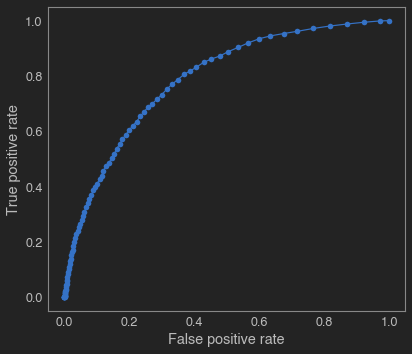

In [62]:
jtplot.style(theme='monokai')

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
pit.plot(fpr, tpr, marker='o')
pit.xlabel("False positive rate")
pit.ylabel("True positive rate")
pit.grid()
pit.show()

In [64]:
roc_auc_score(y_test, y_pred)

0.788897486561814

In [65]:
y_pred_train = rf.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred_train)

1.0

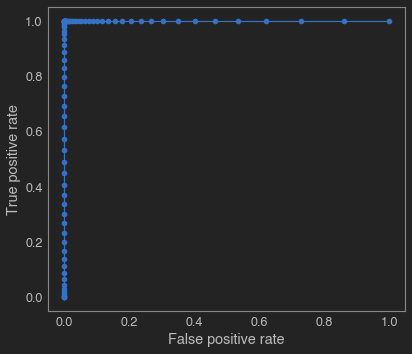

In [66]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
pit.plot(fpr, tpr, marker='o')
pit.xlabel("False positive rate")
pit.ylabel("True positive rate")
pit.grid()
pit.show()

In [12]:
params = {
    'min_samples_split': 500,
    'random_state': 100,
    'max_depth': None,
    'criterion': 'entropy',
#     'n_estimators': 60,
#     'class_weight': 'balanced'
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred_train = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

0.8956517045256882
0.7908703578490267


In [13]:
importances = pd.DataFrame({'features': X_train.columns, 'importance': rf.feature_importances_})
importances.sort_values('importance', ascending=False)[:20]

In [14]:
importances.sort_values('importance', ascending=False)[:20]

,features,importance
5,単勝オッズ,0.190255
4,人気,0.106869
8,1走前人気,0.045979
14,rank_1,0.038406
10,2走前人気,0.030368
12,3走前人気,0.020685
15,rank_2,0.016150
1,年齢,0.013008
16,rank_3,0.007302
3,馬体重増減,0.004690
